# Task 4 - Random Forest vs Boosted Trees

In [2]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt

from time                    import time
from sklearn.metrics         import accuracy_score, mean_squared_error as mse
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing   import LabelBinarizer as LB, StandardScaler, normalize
from sklearn.impute          import SimpleImputer

## Decision Tree Classifier

In [3]:
from sklearn.tree import DecisionTreeClassifier as DTC

## Task 4.1 - Random Forest Classifier

In [4]:
class RandomForestClassifier():
    def __init__(self, num_estimators=10, num_features_per_estimator=None, fraction=0.5, bootstrap=True, voting='soft', progress=True):
        self.num_estimators             = num_estimators
        self.num_features_per_estimator = num_features_per_estimator
        self.fraction                   = fraction
        self.bootstrap                  = bootstrap
        self.voting                     = voting
        self.classes_                   = None
        self.progress                   = progress

        self.models                     = []
        self.features                   = []

    def __data_sampler(self, X, y):
        indices = np.random.choice(X.shape[0], int(X.shape[0] * self.fraction), replace=self.bootstrap)
        X_sampled, y_sampled = X[indices], y[indices]

        if len(np.unique(y_sampled)) != len(np.unique(y)):
            for i in np.unique(y):
                if i not in y_sampled:
                    index = np.random.choice(np.where(y == i)[0], replace=self.bootstrap)
                    X_sampled = np.vstack((X_sampled, np.reshape(X[index], (1, -1))))
                    y_sampled = np.concatenate((y_sampled, np.reshape(y[index], -1)))

        return X_sampled, y_sampled

    def fit(self, X, y):
        for i in range(self.num_estimators):
            if self.progress:
                print(f'Fitting model {i+1}/{self.num_estimators}...')

            X_sampled, y_sampled = self.__data_sampler(X, y)

            if self.num_features_per_estimator is None:
                self.num_features_per_estimator = int(np.sqrt(X.shape[1]))
            features = np.random.choice(X.shape[1], self.num_features_per_estimator, replace=False)

            X_sampled = X_sampled[:, features]

            model = DTC(criterion="gini", max_depth=10, max_leaf_nodes=None)
            model.fit(X_sampled, y_sampled)

            self.models.append(model)
            self.features.append(features)

        self.classes_ = self.models[0].classes_

    def predict(self, X):
        if self.voting == 'soft':
            predictions = []

            for i in range(self.num_estimators):
                predictions.append(self.models[i].predict_proba(X[:, self.features[i]]))

            predictions   = np.mean(predictions, axis=0)
            class_indices = np.argmax(predictions, axis=1)

            return self.classes_[class_indices]

        elif self.voting == 'hard':
            predictions = []

            for i in range(self.num_estimators):
                predictions.append(self.models[i].predict(X[:, self.features[i]]))

            predictions = np.mean(predictions, axis=0)

            return predictions >= 0.5

In [5]:
wine_df = pd.read_csv("./Data/WineQT.csv")
wine_df = wine_df.drop(columns=["Id"])

wine_df["quality"] = np.where(wine_df["quality"] <= 5, 0, 1)
display(wine_df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,1
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,0
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,1


In [6]:
np.random.seed(349)

wine_df_values = wine_df.to_numpy()
wine_df_X, wine_df_Y = wine_df_values[:, :-1], wine_df_values[:, -1]

wine_train_X, wine_val_test_X, wine_train_Y, wine_val_test_Y = train_test_split(wine_df_X, wine_df_Y, train_size=0.7, stratify=wine_df_Y)
wine_val_X, wine_test_X, wine_val_Y, wine_test_Y = train_test_split(wine_val_test_X, wine_val_test_Y, train_size=0.5, stratify=wine_val_test_Y)

In [7]:
# Replacing missing values with mean of the respective columns/features
wine_train_X = SimpleImputer().fit_transform(wine_train_X)
wine_val_X   = SimpleImputer().fit_transform(wine_val_X)
wine_test_X  = SimpleImputer().fit_transform(wine_test_X)

# Dataset normalization
wine_train_X = normalize(wine_train_X)
wine_val_X   = normalize(wine_val_X)
wine_test_X  = normalize(wine_test_X)

# Dataset standardization
wine_train_X = StandardScaler().fit_transform(wine_train_X)
wine_val_X   = StandardScaler().fit_transform(wine_val_X)
wine_test_X  = StandardScaler().fit_transform(wine_test_X)

In [7]:
rf_model = RandomForestClassifier()
rf_model.fit(wine_train_X, wine_train_Y)

Fitting model 1/10...
Fitting model 2/10...
Fitting model 3/10...
Fitting model 4/10...
Fitting model 5/10...
Fitting model 6/10...
Fitting model 7/10...
Fitting model 8/10...
Fitting model 9/10...
Fitting model 10/10...


In [8]:
preds = rf_model.predict(wine_test_X)
print(f'Accuracy: {accuracy_score(wine_test_Y, preds)}')

Accuracy: 0.7441860465116279


## Hyperparameter Tuning

In [34]:
# num_estimators_list             = [5, 10, 15, 20]
# num_features_per_estimator_list = [3, 6, 9, 11, None]
# fraction_list                   = [0.15, 0.25, 0.5, 0.75, 1]
# bootstrap_list                  = [True, False]
# voting_list                     = ['soft', 'hard']

# rf_classifier_params_df = pd.DataFrame(columns=['Num_estimators', 'Num_features_per_estimator', 'Fraction', 'Bootstrap', 'Voting', 'Train_accuracy', 'Val_accuracy', 'Test_accuracy'])
# num_fitted = 0

# for num_estimators in num_estimators_list:
#     for num_features_per_estimator in num_features_per_estimator_list:
#         for fraction in fraction_list:
#             for bootstrap in bootstrap_list:
#                 for voting in voting_list:
#                     rf_model = RandomForestClassifier(num_estimators=num_estimators, num_features_per_estimator=num_features_per_estimator, fraction=fraction, bootstrap=bootstrap, voting=voting, progress=False)
#                     rf_model.fit(wine_train_X, wine_train_Y)

#                     num_fitted += 1
#                     print(f"Model {num_estimators} - {num_features_per_estimator} - {fraction} - {bootstrap} - {voting} fitted ({num_fitted}/400)")

#                     model_params = {
#                         'Num_estimators'            : num_estimators,
#                         'Num_features_per_estimator': num_features_per_estimator,
#                         'Fraction'                  : fraction,
#                         'Bootstrap'                 : bootstrap,
#                         'Voting'                    : voting,
#                         'Train_accuracy'            : accuracy_score(wine_train_Y, rf_model.predict(wine_train_X)),
#                         'Val_accuracy'              : accuracy_score(wine_val_Y, rf_model.predict(wine_val_X)),
#                         'Test_accuracy'             : accuracy_score(wine_test_Y, rf_model.predict(wine_test_X))
#                     }

#                     rf_classifier_params_df = pd.concat([rf_classifier_params_df, pd.DataFrame([model_params])], ignore_index=True)

# rf_classifier_params_df.sort_values(by=['Val_accuracy'], ascending=False, inplace=True)
# display(rf_classifier_params_df)

Model 5 - 3 - 0.15 - True - soft fitted (1/400)
Model 5 - 3 - 0.15 - True - hard fitted (2/400)
Model 5 - 3 - 0.15 - False - soft fitted (3/400)
Model 5 - 3 - 0.15 - False - hard fitted (4/400)
Model 5 - 3 - 0.25 - True - soft fitted (5/400)
Model 5 - 3 - 0.25 - True - hard fitted (6/400)
Model 5 - 3 - 0.25 - False - soft fitted (7/400)
Model 5 - 3 - 0.25 - False - hard fitted (8/400)
Model 5 - 3 - 0.5 - True - soft fitted (9/400)
Model 5 - 3 - 0.5 - True - hard fitted (10/400)
Model 5 - 3 - 0.5 - False - soft fitted (11/400)
Model 5 - 3 - 0.5 - False - hard fitted (12/400)
Model 5 - 3 - 0.75 - True - soft fitted (13/400)
Model 5 - 3 - 0.75 - True - hard fitted (14/400)
Model 5 - 3 - 0.75 - False - soft fitted (15/400)
Model 5 - 3 - 0.75 - False - hard fitted (16/400)
Model 5 - 3 - 1 - True - soft fitted (17/400)
Model 5 - 3 - 1 - True - hard fitted (18/400)
Model 5 - 3 - 1 - False - soft fitted (19/400)
Model 5 - 3 - 1 - False - hard fitted (20/400)
Model 5 - 6 - 0.15 - True - soft fi

,Num_estimators,Num_features_per_estimator,Fraction,Bootstrap,Voting,Train_accuracy,Val_accuracy,Test_accuracy
342,20,9,0.15,False,soft,0.81875,0.777778,0.691860
367,20,11,0.25,False,hard,0.87125,0.742690,0.703488
207,15,3,0.25,False,hard,0.83875,0.742690,0.709302
357,20,9,1.00,True,hard,0.97250,0.742690,0.732558
364,20,11,0.25,True,soft,0.84750,0.736842,0.709302
...,...,...,...,...,...,...,...,...
292,15,None,0.75,True,soft,0.93250,0.549708,0.715116
98,5,None,1.00,False,soft,0.98875,0.543860,0.668605
8,5,3,0.50,True,soft,0.83000,0.543860,0.639535
93,5,None,0.75,True,hard,0.91375,0.538012,0.633721


## Decision Tree Regressor

In [8]:
from sklearn.tree import DecisionTreeRegressor as DTR

## Task 4.1 - Random Forest Regressor

In [9]:
class RandomForestRegressor():
    def __init__(self, num_estimators=10, num_features_per_estimator=None, fraction=0.5, bootstrap=True, voting='soft', progress=True):
        self.num_estimators             = num_estimators
        self.num_features_per_estimator = num_features_per_estimator
        self.fraction                   = fraction
        self.bootstrap                  = bootstrap
        self.voting                     = voting
        self.progress                   = progress

        self.models                     = []
        self.features                   = []

    def __data_sampler(self, X, y):
        indices = np.random.choice(X.shape[0], int(X.shape[0] * self.fraction), replace=self.bootstrap)
        X_sampled, y_sampled = X[indices], y[indices]

        return X_sampled, y_sampled

    def fit(self, X, y):
        for i in range(self.num_estimators):
            if self.progress:
                print(f'Fitting model {i+1}/{self.num_estimators}...')

            X_sampled, y_sampled = self.__data_sampler(X, y)

            if self.num_features_per_estimator is None:
                self.num_features_per_estimator = int(np.sqrt(X.shape[1]))
            features = np.random.choice(X.shape[1], self.num_features_per_estimator, replace=False)

            X_sampled = X_sampled[:, features]

            model = DTR(criterion="absolute_error", max_depth=10, max_leaf_nodes=None)
            model.fit(X_sampled, y_sampled)

            self.models.append((model))
            self.features.append(features)

    def predict(self, X, y):
        if self.voting == 'soft':
            predictions = []
            confidences = []

            for i in range(self.num_estimators):
                prediction = self.models[i].predict(X[:, self.features[i]])
                predictions.append(prediction)
                confidences.append(1 / mse(y, prediction))

            predictions = np.reshape(predictions, (len(self.models), -1))
            confidences = np.reshape(confidences, (-1, 1))

            weighted_predictions = np.sum(predictions * confidences, axis=0) / np.sum(confidences)
            
            return weighted_predictions
        
        elif self.voting == 'hard':
            predictions = []

            for i in range(self.num_estimators):
                predictions.append(self.models[i].predict(X[:, self.features[i]]))

            return np.mean(predictions, axis=0)

In [10]:
housing_df = pd.read_csv("./Data/HousingData.csv")
housing_df_values = housing_df.to_numpy()
display(housing_df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [11]:
np.random.seed(41)

housing_df_X, housing_df_Y = housing_df_values[:, :-1], housing_df_values[:, -1]

housing_train_X, housing_val_test_X, housing_train_Y, housing_val_test_Y = train_test_split(housing_df_X,       housing_df_Y,       train_size=0.7)
housing_val_X,   housing_test_X,     housing_val_Y,   housing_test_Y     = train_test_split(housing_val_test_X, housing_val_test_Y, train_size=0.5)

In [12]:
# Replacing missing values with mean of the respective columns/features
housing_train_X = SimpleImputer().fit_transform(housing_train_X)
housing_val_X   = SimpleImputer().fit_transform(housing_val_X)
housing_test_X  = SimpleImputer().fit_transform(housing_test_X)

# Dataset normalization
housing_train_X = normalize(housing_train_X)
housing_val_X   = normalize(housing_val_X)
housing_test_X  = normalize(housing_test_X)

# Dataset standardization
housing_train_X = StandardScaler().fit_transform(housing_train_X)
housing_val_X   = StandardScaler().fit_transform(housing_val_X)
housing_test_X  = StandardScaler().fit_transform(housing_test_X)

In [15]:
rf_reg = RandomForestRegressor()
rf_reg.fit(housing_train_X, housing_train_Y)

Fitting model 1/10...
Fitting model 2/10...
Fitting model 3/10...
Fitting model 4/10...
Fitting model 5/10...
Fitting model 6/10...
Fitting model 7/10...
Fitting model 8/10...
Fitting model 9/10...
Fitting model 10/10...


In [16]:
preds = rf_reg.predict(housing_test_X, housing_test_Y)
loss  = mse(housing_test_Y, preds)
print(f"Test loss: {loss}")

Test loss: 13.971014421930503


## Hyperparameter Tuning

In [50]:
# num_estimators_list             = [5, 10, 15, 20]
# num_features_per_estimator_list = [3, 6, 9, 11, None]
# fraction_list                   = [0.15, 0.25, 0.5, 0.75, 1]
# bootstrap_list                  = [True, False]
# voting_list                     = ['soft', 'hard']

# rf_classifier_params_df = pd.DataFrame(columns=['Num_estimators', 'Num_features_per_estimator', 'Fraction', 'Bootstrap', 'Voting', 'Train_loss', 'Val_loss', 'Test_loss'])
# num_fitted = 0

# for num_estimators in num_estimators_list:
#     for num_features_per_estimator in num_features_per_estimator_list:
#         for fraction in fraction_list:
#             for bootstrap in bootstrap_list:
#                 for voting in voting_list:
#                     rf_model = RandomForestRegressor(num_estimators=num_estimators, num_features_per_estimator=num_features_per_estimator, fraction=fraction, bootstrap=bootstrap, voting=voting, progress=False)
#                     rf_model.fit(wine_train_X, wine_train_Y)

#                     num_fitted += 1
#                     print(f"Model {num_estimators} - {num_features_per_estimator} - {fraction} - {bootstrap} - {voting} fitted ({num_fitted}/400)")

#                     model_params = {
#                         'Num_estimators'            : num_estimators,
#                         'Num_features_per_estimator': num_features_per_estimator,
#                         'Fraction'                  : fraction,
#                         'Bootstrap'                 : bootstrap,
#                         'Voting'                    : voting,
#                         'Train_loss'                : mse(wine_train_Y, rf_model.predict(wine_train_X, wine_train_Y)),
#                         'Val_loss'                  : mse(wine_val_Y, rf_model.predict(wine_val_X,     wine_val_Y)),
#                         'Test_loss'                 : mse(wine_test_Y, rf_model.predict(wine_test_X,   wine_test_Y))
#                     }

#                     rf_classifier_params_df = pd.concat([rf_classifier_params_df, pd.DataFrame([model_params])], ignore_index=True)

# rf_classifier_params_df.sort_values(by=['Val_loss'], ascending=False, inplace=True)
# display(rf_classifier_params_df)

Model 5 - 3 - 0.15 - True - soft fitted (1/400)
Model 5 - 3 - 0.15 - True - hard fitted (2/400)
Model 5 - 3 - 0.15 - False - soft fitted (3/400)
Model 5 - 3 - 0.15 - False - hard fitted (4/400)
Model 5 - 3 - 0.25 - True - soft fitted (5/400)
Model 5 - 3 - 0.25 - True - hard fitted (6/400)
Model 5 - 3 - 0.25 - False - soft fitted (7/400)
Model 5 - 3 - 0.25 - False - hard fitted (8/400)
Model 5 - 3 - 0.5 - True - soft fitted (9/400)
Model 5 - 3 - 0.5 - True - hard fitted (10/400)
Model 5 - 3 - 0.5 - False - soft fitted (11/400)
Model 5 - 3 - 0.5 - False - hard fitted (12/400)
Model 5 - 3 - 0.75 - True - soft fitted (13/400)
Model 5 - 3 - 0.75 - True - hard fitted (14/400)
Model 5 - 3 - 0.75 - False - soft fitted (15/400)
Model 5 - 3 - 0.75 - False - hard fitted (16/400)
Model 5 - 3 - 1 - True - soft fitted (17/400)
Model 5 - 3 - 1 - True - hard fitted (18/400)
Model 5 - 3 - 1 - False - soft fitted (19/400)
Model 5 - 3 - 1 - False - hard fitted (20/400)
Model 5 - 6 - 0.15 - True - soft fi

,Num_estimators,Num_features_per_estimator,Fraction,Bootstrap,Voting,Train_loss,Val_loss,Test_loss
19,5,3,1.00,False,hard,0.175850,0.352982,0.266047
79,5,11,1.00,False,hard,0.172700,0.339415,0.325814
190,10,None,0.50,False,soft,0.192495,0.322602,0.239112
178,10,11,1.00,False,soft,0.159685,0.321496,0.295848
114,10,3,0.75,False,soft,0.186167,0.321088,0.241020
...,...,...,...,...,...,...,...,...
240,15,9,0.15,True,soft,0.172567,0.216285,0.196753
167,10,11,0.25,False,hard,0.162212,0.214912,0.198895
160,10,11,0.15,True,soft,0.184735,0.210858,0.195807
344,20,9,0.25,True,soft,0.160088,0.210673,0.193289


## Task 4.2.1 - AdaBoost Classifier

In [13]:
class AdaBoostClassifier():
    def __init__(self, num_estimators=10, num_max_leaves=None, progress=True):
        self.num_estimators = num_estimators
        self.num_max_leaves = num_max_leaves
        self.progress       = progress
        self.weights        = None
        self.alphas         = None

        self.models         = []

    def fit(self, X, y):
        changed_y    = np.where(y == 0, -1, 1)
        self.weights = np.full((X.shape[0]), 1 / X.shape[0])
        self.alphas  = np.zeros(self.num_estimators)

        for i in range(self.num_estimators):
            if self.progress:
                print(f'Fitting model {i+1}/{self.num_estimators}...')

            model = DTC(max_depth=1, max_leaf_nodes=self.num_max_leaves)
            model.fit(X, changed_y, sample_weight=self.weights)

            preds   = model.predict(X)
            epsilon = np.sum(self.weights * (preds != changed_y)) / np.sum(self.weights)

            self.alphas[i] = 0.5 * np.log((1 - epsilon) / epsilon)

            self.weights = self.weights * np.exp(-self.alphas[i] * changed_y * preds)
            self.weights = self.weights / np.sum(self.weights)

            self.models.append(model)

    def predict(self, X):
        predictions = []

        for i in range(self.num_estimators):
            predictions.append(self.alphas[i] * self.models[i].predict(X))

        predictions = np.sum(predictions, axis=0)

        return np.where(predictions > 0, 1, 0)

In [37]:
np.random.seed(349)

In [38]:
ac = AdaBoostClassifier(num_estimators=100, progress=False)
ac.fit(wine_train_X, wine_train_Y)

In [39]:
ac_preds = ac.predict(wine_test_X)
print(f'Accuracy: {accuracy_score(wine_test_Y, ac_preds)}')

Accuracy: 0.7151162790697675


## AdaBoost Classifier Hyperparameter Tuning

In [41]:
# num_estimators_list = list((np.arange(10) + 1) * 10)
# num_max_leaves_list = [8, 12, 16, 24, 32, None]

# ab_classifier_params_df = pd.DataFrame(columns=['Num_estimators', 'Num_max_leaves', 'Train_accuracy', 'Val_accuracy', 'Test_accuracy'])
# num_fitted = 0

# for num_estimators in num_estimators_list:
#     for num_max_leaves in num_max_leaves_list:
#         ac = AdaBoostClassifier(num_estimators=num_estimators, num_max_leaves=num_max_leaves, progress=False)
#         ac.fit(wine_train_X, wine_train_Y)

#         num_fitted += 1
#         print(f"Model {num_estimators} - {num_max_leaves} fitted ({num_fitted}/60)")

#         model_params = {
#             'Num_estimators' : num_estimators,
#             'Num_max_leaves' : num_max_leaves,
#             'Train_accuracy' : accuracy_score(wine_train_Y, ac.predict(wine_train_X)),
#             'Val_accuracy'   : accuracy_score(wine_val_Y,   ac.predict(wine_val_X)),
#             'Test_accuracy'  : accuracy_score(wine_test_Y,  ac.predict(wine_test_X))
#         }

#         ab_classifier_params_df = pd.concat([ab_classifier_params_df, pd.DataFrame([model_params])], ignore_index=True)

# ab_classifier_params_df.sort_values(by=['Val_accuracy'], ascending=False, inplace=True)
# display(ab_classifier_params_df)

Model 10 - 8 fitted (1/60)
Model 10 - 12 fitted (2/60)
Model 10 - 16 fitted (3/60)
Model 10 - 24 fitted (4/60)
Model 10 - 32 fitted (5/60)
Model 10 - None fitted (6/60)
Model 20 - 8 fitted (7/60)
Model 20 - 12 fitted (8/60)
Model 20 - 16 fitted (9/60)
Model 20 - 24 fitted (10/60)
Model 20 - 32 fitted (11/60)
Model 20 - None fitted (12/60)
Model 30 - 8 fitted (13/60)
Model 30 - 12 fitted (14/60)
Model 30 - 16 fitted (15/60)
Model 30 - 24 fitted (16/60)
Model 30 - 32 fitted (17/60)
Model 30 - None fitted (18/60)
Model 40 - 8 fitted (19/60)
Model 40 - 12 fitted (20/60)
Model 40 - 16 fitted (21/60)
Model 40 - 24 fitted (22/60)
Model 40 - 32 fitted (23/60)
Model 40 - None fitted (24/60)
Model 50 - 8 fitted (25/60)
Model 50 - 12 fitted (26/60)
Model 50 - 16 fitted (27/60)
Model 50 - 24 fitted (28/60)
Model 50 - 32 fitted (29/60)
Model 50 - None fitted (30/60)
Model 60 - 8 fitted (31/60)
Model 60 - 12 fitted (32/60)
Model 60 - 16 fitted (33/60)
Model 60 - 24 fitted (34/60)
Model 60 - 32 fitte

,Num_estimators,Num_max_leaves,Train_accuracy,Val_accuracy,Test_accuracy
12,30,8,0.73375,0.707602,0.720930
17,30,None,0.73375,0.707602,0.720930
15,30,24,0.73375,0.707602,0.720930
14,30,16,0.73375,0.707602,0.720930
13,30,12,0.73375,0.707602,0.720930
16,30,32,0.73375,0.707602,0.720930
6,20,8,0.72000,0.701754,0.709302
7,20,12,0.72000,0.701754,0.709302
9,20,24,0.72000,0.701754,0.709302
10,20,32,0.72000,0.701754,0.709302


## Task 4.2.2 - Gradient Boosted Classifier

In [14]:
class GradientBoostClassifier():
    def __init__(self, num_estimators=100, max_leaves=16, lr=0.1, progress=True):
        self.num_estimators = num_estimators
        self.max_leaves     = max_leaves
        self.lr             = lr
        self.progress       = progress

        self.log_odds       = None
        self.residuals      = None
        self.prev_probs     = None
        self.models         = []
        self.leaf_outputs   = []
        self.model_log_odds = []

    def __calc_odds(self, y):
        odds          = np.maximum(np.sum(y), len(y) - np.sum(y)) / np.minimum(np.sum(y), len(y) - np.sum(y))
        self.log_odds = np.log(odds)

    def fit(self, X, y):
        self.__calc_odds(y)

        self.prev_probs = np.full(len(y), np.exp(self.log_odds) / (1 + np.exp(self.log_odds)))
        self.residuals  = y - self.prev_probs

        for i in range(self.num_estimators):
            if self.progress:
                print(f'Fitting model {i+1}/{self.num_estimators}...')

            model = DTR(max_depth=5, max_leaf_nodes=self.max_leaves)
            model.fit(X, self.residuals)

            self.models.append(model)

            leaf_indices  = model.apply(X)
            unique_leaves = np.unique(leaf_indices)

            leaf_outputs = np.zeros(np.max(leaf_indices) + 1)

            for leaf in unique_leaves:
                leaf_outputs[leaf] = np.sum(self.residuals[leaf_indices == leaf]) / np.sum(self.prev_probs[leaf_indices == leaf] * (1 - self.prev_probs[leaf_indices == leaf]))

            self.leaf_outputs.append(leaf_outputs)

            self.model_log_odds.append(leaf_outputs[leaf_indices])
            self.prev_probs = self.log_odds + self.lr * np.sum(self.model_log_odds, axis=0)
            self.residuals  = y - self.prev_probs

    def predict(self, X):
        predictions = np.full(len(X), self.log_odds)

        for i in range(self.num_estimators):
            leaf_indices = self.models[i].apply(X)

            predictions += self.lr * self.leaf_outputs[i][leaf_indices]

        return np.where(predictions >= 0.5, 1, 0)

In [43]:
gbc = GradientBoostClassifier(num_estimators=5)
gbc.fit(wine_train_X, wine_train_Y)

Fitting model 1/5...
Fitting model 2/5...
Fitting model 3/5...
Fitting model 4/5...
Fitting model 5/5...


In [44]:
preds = gbc.predict(wine_test_X)
print(f'Accuracy: {accuracy_score(wine_test_Y, preds)}')

Accuracy: 0.6686046511627907


## Gradient Boosted Classifier Hyperparameter Tuning

In [45]:
# num_estimators_list = list((np.arange(10) + 1) * 10)
# max_leaves_list     = [8, 12, 16, 24, 32, None]
# lr_list             = [0.1, 0.5, 1]

# gb_classifier_params_df = pd.DataFrame(columns=['Num_estimators', 'Max_leaves', 'Learning_rate', 'Train_accuracy', 'Val_accuracy', 'Test_accuracy'])
# num_fitted = 0

# for num_estimators in num_estimators_list:
#     for max_leaves in max_leaves_list:
#         for lr in lr_list:
#             gbc = GradientBoostClassifier(num_estimators=num_estimators, max_leaves=max_leaves, lr=lr, progress=False)
#             gbc.fit(wine_train_X, wine_train_Y)

#             num_fitted += 1
#             print(f"Model {num_estimators} - {max_leaves} - {lr} fitted ({num_fitted}/180)")

#             model_params = {
#                 'Num_estimators' : num_estimators,
#                 'Max_leaves'     : max_leaves,
#                 'Learning_rate'  : lr,
#                 'Train_accuracy' : accuracy_score(wine_train_Y, gbc.predict(wine_train_X)),
#                 'Val_accuracy'   : accuracy_score(wine_val_Y,   gbc.predict(wine_val_X)),
#                 'Test_accuracy'  : accuracy_score(wine_test_Y,  gbc.predict(wine_test_X))
#             }

#             gb_classifier_params_df = pd.concat([gb_classifier_params_df, pd.DataFrame([model_params])], ignore_index=True)

# gb_classifier_params_df.sort_values(by=['Val_accuracy'], ascending=False, inplace=True)
# display(gb_classifier_params_df)

Model 10 - 8 - 0.1 fitted (1/180)
Model 10 - 8 - 0.5 fitted (2/180)
Model 10 - 8 - 1 fitted (3/180)
Model 10 - 12 - 0.1 fitted (4/180)
Model 10 - 12 - 0.5 fitted (5/180)
Model 10 - 12 - 1 fitted (6/180)
Model 10 - 16 - 0.1 fitted (7/180)
Model 10 - 16 - 0.5 fitted (8/180)
Model 10 - 16 - 1 fitted (9/180)
Model 10 - 24 - 0.1 fitted (10/180)
Model 10 - 24 - 0.5 fitted (11/180)
Model 10 - 24 - 1 fitted (12/180)
Model 10 - 32 - 0.1 fitted (13/180)
Model 10 - 32 - 0.5 fitted (14/180)
Model 10 - 32 - 1 fitted (15/180)
Model 10 - None - 0.1 fitted (16/180)
Model 10 - None - 0.5 fitted (17/180)
Model 10 - None - 1 fitted (18/180)
Model 20 - 8 - 0.1 fitted (19/180)
Model 20 - 8 - 0.5 fitted (20/180)
Model 20 - 8 - 1 fitted (21/180)
Model 20 - 12 - 0.1 fitted (22/180)
Model 20 - 12 - 0.5 fitted (23/180)
Model 20 - 12 - 1 fitted (24/180)
Model 20 - 16 - 0.1 fitted (25/180)
Model 20 - 16 - 0.5 fitted (26/180)
Model 20 - 16 - 1 fitted (27/180)
Model 20 - 24 - 0.1 fitted (28/180)
Model 20 - 24 - 0.5

,Num_estimators,Max_leaves,Learning_rate,Train_accuracy,Val_accuracy,Test_accuracy
123,70,None,0.1,0.81250,0.730994,0.703488
138,80,32,0.1,0.81250,0.725146,0.709302
177,100,None,0.1,0.84625,0.725146,0.709302
114,70,16,0.1,0.93250,0.719298,0.656977
30,20,32,0.1,0.84125,0.719298,0.703488
...,...,...,...,...,...,...
168,100,16,0.1,0.38625,0.421053,0.337209
150,90,16,0.1,0.38625,0.421053,0.337209
60,40,16,0.1,0.38625,0.421053,0.337209
132,80,16,0.1,0.38625,0.421053,0.337209


## Task 4.2.1 - Comparision between random forest and boosted tree classifiers

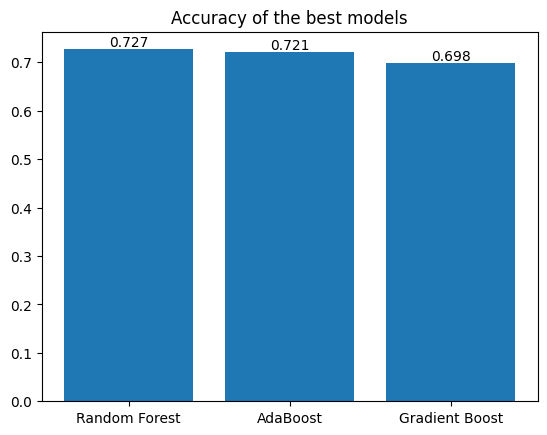

In [46]:
best_rf_classifier = RandomForestClassifier(num_estimators=20, num_features_per_estimator=9, fraction=0.15, bootstrap=False, voting='soft', progress=False)
best_rf_classifier.fit(wine_train_X, wine_train_Y)
best_rf_accuracy = accuracy_score(wine_test_Y, best_rf_classifier.predict(wine_test_X))

best_ab_classifier = AdaBoostClassifier(num_estimators=30, num_max_leaves=8, progress=False)
best_ab_classifier.fit(wine_train_X, wine_train_Y)
best_ab_accuracy = accuracy_score(wine_test_Y, best_ab_classifier.predict(wine_test_X))

best_gb_classifier = GradientBoostClassifier(num_estimators=70, max_leaves=None, lr=0.1, progress=False)
best_gb_classifier.fit(wine_train_X, wine_train_Y)
best_gb_accuracy = accuracy_score(wine_test_Y, best_gb_classifier.predict(wine_test_X))

acc_bar = plt.bar(['Random Forest', 'AdaBoost', 'Gradient Boost'], [best_rf_accuracy, best_ab_accuracy, best_gb_accuracy])
plt.bar_label(acc_bar, fmt='%.3f')

plt.title('Accuracy of the best models')
plt.show()

## Task 4.2.2 - Comparision of training times based on num_estimators

Trained on 10 estimators
Trained on 20 estimators
Trained on 30 estimators
Trained on 40 estimators
Trained on 50 estimators
Trained on 60 estimators
Trained on 70 estimators
Trained on 80 estimators
Trained on 90 estimators
Trained on 100 estimators


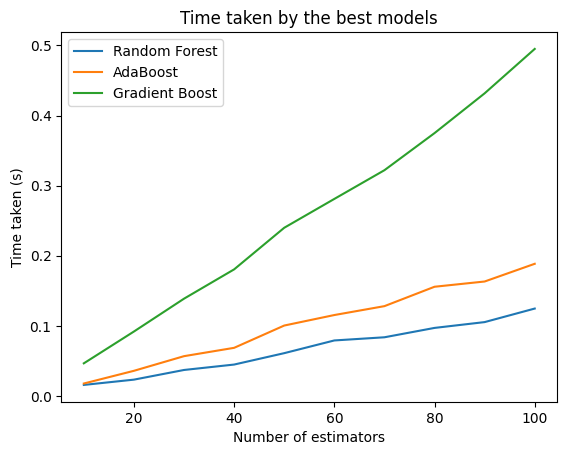

In [49]:
num_estimators_list = list((np.arange(10) + 1) * 10)

rf_times, ab_times, gb_times = [], [], []

for num_estimators in num_estimators_list:
    rf_time = time()
    best_rf_classifier = RandomForestClassifier(num_estimators=num_estimators, num_features_per_estimator=9, fraction=0.15, bootstrap=False, voting='soft', progress=False)
    best_rf_classifier.fit(wine_train_X, wine_train_Y)
    rf_times.append(time() - rf_time)

    ab_time = time()
    best_ab_classifier = AdaBoostClassifier(num_estimators=num_estimators, num_max_leaves=8, progress=False)
    best_ab_classifier.fit(wine_train_X, wine_train_Y)
    ab_times.append(time() - ab_time)

    gb_time = time()
    best_gb_classifier = GradientBoostClassifier(num_estimators=num_estimators, max_leaves=None, lr=0.1, progress=False)
    best_gb_classifier.fit(wine_train_X, wine_train_Y)
    gb_times.append(time() - gb_time)

    print(f"Trained on {num_estimators} estimators")

plt.plot(num_estimators_list, rf_times, label='Random Forest')
plt.plot(num_estimators_list, ab_times, label='AdaBoost')
plt.plot(num_estimators_list, gb_times, label='Gradient Boost')

plt.xlabel('Number of estimators')
plt.ylabel('Time taken (s)')
plt.title('Time taken by the best models')
plt.legend()

plt.show()

## Task 4.2.1 - AdaBoost Regressor

In [15]:
class AdaBoostRegressor():
    def __init__(self, num_estimators=10, num_max_leaves=None, error_threshold=0.5, progress=True):
        self.num_estimators  = num_estimators
        self.num_max_leaves  = num_max_leaves
        self.error_threshold = error_threshold
        self.progress        = progress
        self.weights         = None
        self.betas           = None

        self.models          = []
        self.model_errors    = None

    def fit(self, X, y):
        self.weights      = np.full((X.shape[0]), 1 / X.shape[0])
        self.betas        = np.zeros(self.num_estimators)
        self.model_errors = np.zeros(self.num_estimators)

        for i in range(self.num_estimators):
            if self.progress:
                print(f'Fitting model {i+1}/{self.num_estimators}...')            

            resampled_indices = np.random.choice(X.shape[0], X.shape[0], replace=True, p=self.weights)
            X_resampled, y_resampled = X[resampled_indices], y[resampled_indices]

            model = DTR(max_depth=1, max_leaf_nodes=self.num_max_leaves)
            model.fit(X_resampled, y_resampled)

            self.models.append(model)

            y_preds      = model.predict(X)
            sample_error = np.abs(y - y_preds) / np.max(np.abs(y - y_preds))
            model_error  = np.sum(self.weights * sample_error)

            self.model_errors[i] = model_error

            if model_error > self.error_threshold:
                self.num_estimators = i
                break

            self.betas[i] = model_error / (1 - model_error)

            new_weights = self.weights * np.power(self.betas[i], 1 - sample_error)
            self.weights = new_weights / np.sum(new_weights)

    def predict(self, X):
        predictions = []

        for i in range(self.num_estimators):
            predictions.append(self.models[i].predict(X))

        predictions = np.array(predictions)
        final_preds = []

        for i in range(X.shape[0]):
            sample_preds        = predictions[:, i]
            sorted_pred_indices = np.argsort(sample_preds)

            sample_preds  = sample_preds[sorted_pred_indices]
            weights       = self.weights[sorted_pred_indices]

            cum_weights   = np.cumsum(weights)
            median_weight = np.argmax(cum_weights >= np.sum(weights) / 2)

            final_preds.append(sample_preds[median_weight])

        return np.array(final_preds)

In [103]:
np.random.seed(41)

In [104]:
ar = AdaBoostRegressor(num_estimators=100, progress=False)
ar.fit(housing_train_X, housing_train_Y)

In [105]:
ar_preds = ar.predict(housing_test_X)
loss     = mse(housing_test_Y, ar_preds)
print(f'Loss: {loss}')

Loss: 38.524677089211664


## AdaBoost Regressor Hyperparameter Tuning

In [106]:
# num_estimators_list = list((np.arange(10) + 1) * 10)
# num_max_leaves_list = [8, 12, 16, 24, 32, None]

# ab_regressor_params_df = pd.DataFrame(columns=['Num_estimators', 'Num_max_leaves', 'Train_loss', 'Val_loss', 'Test_loss'])
# num_fitted = 0

# for num_estimators in num_estimators_list:
#     for num_max_leaves in num_max_leaves_list:
#         ar = AdaBoostRegressor(num_estimators=num_estimators, num_max_leaves=num_max_leaves, progress=False)
#         ar.fit(housing_train_X, housing_train_Y)

#         num_fitted += 1
#         print(f"Model {num_estimators} - {num_max_leaves} fitted ({num_fitted}/60)")

#         model_params = {
#             'Num_estimators' : num_estimators,
#             'Num_max_leaves' : num_max_leaves,
#             'Train_loss'     : mse(housing_train_Y, ar.predict(housing_train_X)),
#             'Val_loss'       : mse(housing_val_Y,   ar.predict(housing_val_X)),
#             'Test_loss'      : mse(housing_test_Y,  ar.predict(housing_test_X))
#         }

#         ab_regressor_params_df = pd.concat([ab_regressor_params_df, pd.DataFrame([model_params])], ignore_index=True)

# ab_regressor_params_df.sort_values(by=['Val_loss'], ascending=False, inplace=True)
# display(ab_regressor_params_df)

Model 10 - 8 fitted (1/60)
Model 10 - 12 fitted (2/60)
Model 10 - 16 fitted (3/60)
Model 10 - 24 fitted (4/60)
Model 10 - 32 fitted (5/60)
Model 10 - None fitted (6/60)
Model 20 - 8 fitted (7/60)
Model 20 - 12 fitted (8/60)
Model 20 - 16 fitted (9/60)
Model 20 - 24 fitted (10/60)
Model 20 - 32 fitted (11/60)
Model 20 - None fitted (12/60)
Model 30 - 8 fitted (13/60)
Model 30 - 12 fitted (14/60)
Model 30 - 16 fitted (15/60)
Model 30 - 24 fitted (16/60)
Model 30 - 32 fitted (17/60)
Model 30 - None fitted (18/60)
Model 40 - 8 fitted (19/60)
Model 40 - 12 fitted (20/60)
Model 40 - 16 fitted (21/60)
Model 40 - 24 fitted (22/60)
Model 40 - 32 fitted (23/60)
Model 40 - None fitted (24/60)
Model 50 - 8 fitted (25/60)
Model 50 - 12 fitted (26/60)
Model 50 - 16 fitted (27/60)
Model 50 - 24 fitted (28/60)
Model 50 - 32 fitted (29/60)
Model 50 - None fitted (30/60)
Model 60 - 8 fitted (31/60)
Model 60 - 12 fitted (32/60)
Model 60 - 16 fitted (33/60)
Model 60 - 24 fitted (34/60)
Model 60 - 32 fitte

,Num_estimators,Num_max_leaves,Train_loss,Val_loss,Test_loss
16,30,32,74.887682,84.084798,83.213029
58,100,32,64.988620,80.892253,85.882624
37,70,12,65.776725,76.299293,91.609265
18,40,8,64.422656,74.164793,76.323867
55,100,12,85.974501,72.605066,94.448964
15,30,24,62.662296,70.962207,50.718217
33,60,24,67.932192,68.343061,72.152545
5,10,None,58.603478,65.378055,74.620445
25,50,12,63.449096,64.398674,76.731789
38,70,16,59.846391,63.798346,67.551360


## Task 4.2.2 - Gradient Boosted Regressor

In [16]:
class GradientBoostRegressor():
    def __init__(self, num_estimators=10, max_leaves=16, lr=0.1, progress=True):
        self.num_estimators = num_estimators
        self.max_leaves     = max_leaves
        self.lr             = lr
        self.progress       = progress

        self.initial_mean   = None
        self.residuals      = None
        self.prev_preds     = None
        self.models         = []
        self.leaf_outputs   = []
        self.model_outputs  = []

    def fit(self, X, y):
        self.initial_mean = np.mean(y)
        self.prev_preds   = np.full(len(y), np.mean(y))
        self.residuals    = y - self.prev_preds

        for i in range(self.num_estimators):
            if self.progress:
                print(f'Fitting model {i+1}/{self.num_estimators}...')

            model = DTR(max_depth=5, max_leaf_nodes=self.max_leaves)
            model.fit(X, self.residuals)

            self.models.append(model)

            leaf_indices  = model.apply(X)
            unique_leaves = np.unique(leaf_indices)

            leaf_outputs = np.zeros(np.max(leaf_indices) + 1)

            for leaf in unique_leaves:
                leaf_outputs[leaf] = np.mean(self.residuals[leaf_indices == leaf])

            self.leaf_outputs.append(leaf_outputs)

            self.model_outputs.append(leaf_outputs[leaf_indices])
            self.prev_preds = self.initial_mean + self.lr * np.sum(self.model_outputs, axis=0)
            self.residuals  = y - self.prev_preds

    def predict(self, X):
        predictions = np.full(len(X), self.initial_mean)

        for i in range(self.num_estimators):
            leaf_indices = self.models[i].apply(X)

            predictions += self.lr * self.leaf_outputs[i][leaf_indices]

        return predictions

In [108]:
gbr = GradientBoostRegressor(num_estimators=10)
gbr.fit(housing_train_X, housing_train_Y)

Fitting model 1/10...
Fitting model 2/10...
Fitting model 3/10...
Fitting model 4/10...
Fitting model 5/10...
Fitting model 6/10...
Fitting model 7/10...
Fitting model 8/10...
Fitting model 9/10...
Fitting model 10/10...


In [109]:
gbr_preds = gbr.predict(housing_test_X)
loss      = mse(housing_test_Y, gbr_preds)
print(f'Loss: {loss}')

Loss: 16.651089035368415


## Gradient Boosted Regressor Hyperparameter Tuning

In [110]:
# num_estimators_list = list((np.arange(10) + 1) * 10)
# num_max_leaves_list = [8, 12, 16, 24, 32, None]
# lr_list             = [0.1, 0.5, 1]

# gb_regressor_params_df = pd.DataFrame(columns=['Num_estimators', 'Max_leaves', 'Learning_rate', 'Train_loss', 'Val_loss', 'Test_loss'])
# num_fitted = 0

# for num_estimators in num_estimators_list:
#     for max_leaves in num_max_leaves_list:
#         for lr in lr_list:
#             gbr = GradientBoostRegressor(num_estimators=num_estimators, max_leaves=max_leaves, lr=lr, progress=False)
#             gbr.fit(housing_train_X, housing_train_Y)

#             num_fitted += 1
#             print(f"Model {num_estimators} - {max_leaves} - {lr} fitted ({num_fitted}/180)")

#             model_params = {
#                 'Num_estimators' : num_estimators,
#                 'Max_leaves'     : max_leaves,
#                 'Learning_rate'  : lr,
#                 'Train_loss'     : mse(housing_train_Y, gbr.predict(housing_train_X)),
#                 'Val_loss'       : mse(housing_val_Y,   gbr.predict(housing_val_X)),
#                 'Test_loss'      : mse(housing_test_Y,  gbr.predict(housing_test_X))
#             }

#             gb_regressor_params_df = pd.concat([gb_regressor_params_df, pd.DataFrame([model_params])], ignore_index=True)

# gb_regressor_params_df.sort_values(by=['Val_loss'], ascending=False, inplace=True)
# display(gb_regressor_params_df)

Model 10 - 8 - 0.1 fitted (1/180)
Model 10 - 8 - 0.5 fitted (2/180)
Model 10 - 8 - 1 fitted (3/180)
Model 10 - 12 - 0.1 fitted (4/180)
Model 10 - 12 - 0.5 fitted (5/180)
Model 10 - 12 - 1 fitted (6/180)
Model 10 - 16 - 0.1 fitted (7/180)
Model 10 - 16 - 0.5 fitted (8/180)
Model 10 - 16 - 1 fitted (9/180)
Model 10 - 24 - 0.1 fitted (10/180)
Model 10 - 24 - 0.5 fitted (11/180)
Model 10 - 24 - 1 fitted (12/180)
Model 10 - 32 - 0.1 fitted (13/180)
Model 10 - 32 - 0.5 fitted (14/180)
Model 10 - 32 - 1 fitted (15/180)
Model 10 - None - 0.1 fitted (16/180)
Model 10 - None - 0.5 fitted (17/180)
Model 10 - None - 1 fitted (18/180)
Model 20 - 8 - 0.1 fitted (19/180)
Model 20 - 8 - 0.5 fitted (20/180)
Model 20 - 8 - 1 fitted (21/180)
Model 20 - 12 - 0.1 fitted (22/180)
Model 20 - 12 - 0.5 fitted (23/180)
Model 20 - 12 - 1 fitted (24/180)
Model 20 - 16 - 0.1 fitted (25/180)
Model 20 - 16 - 0.5 fitted (26/180)
Model 20 - 16 - 1 fitted (27/180)
Model 20 - 24 - 0.1 fitted (28/180)
Model 20 - 24 - 0.5

,Num_estimators,Max_leaves,Learning_rate,Train_loss,Val_loss,Test_loss
32,20,32,1.0,1.827081e-02,44.396693,35.988185
11,10,24,1.0,3.246706e-01,44.197760,27.999581
29,20,24,1.0,2.146036e-02,43.480660,25.994923
35,20,None,1.0,1.827081e-02,41.844813,36.662390
107,60,None,1.0,2.471845e-07,41.783732,31.244653
...,...,...,...,...,...,...
69,40,None,0.1,9.577731e-01,13.654730,16.897175
123,70,None,0.1,3.710646e-01,13.635165,17.063726
153,90,24,0.1,2.980175e-01,13.617473,17.150205
156,90,32,0.1,2.481920e-01,13.528879,16.796652


## Task 4.2.1 - Comparision between random forest and boosted tree regressors

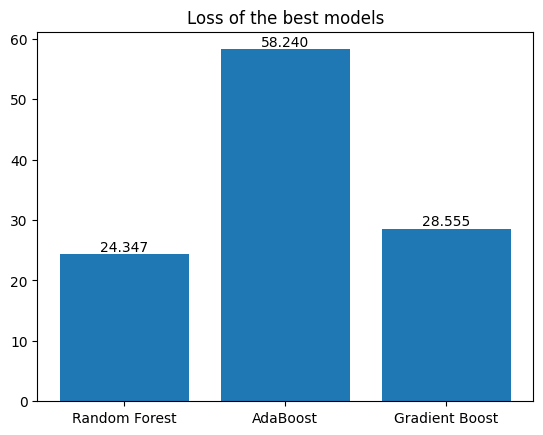

In [113]:
best_rf_regressor = RandomForestRegressor(num_estimators=5, num_features_per_estimator=3, fraction=1, bootstrap=False, voting='hard', progress=False)
best_rf_regressor.fit(housing_train_X, housing_train_Y)
best_rf_loss = mse(housing_test_Y, best_rf_regressor.predict(housing_test_X, housing_test_Y))

best_ab_regressor = AdaBoostRegressor(num_estimators=30, num_max_leaves=32, progress=False)
best_ab_regressor.fit(housing_train_X, housing_train_Y)
best_ab_loss = mse(housing_test_Y, best_ab_regressor.predict(housing_test_X))

best_gb_regressor = GradientBoostRegressor(num_estimators=20, max_leaves=32, lr=1, progress=False)
best_gb_regressor.fit(housing_train_X, housing_train_Y)
best_gb_loss = mse(housing_test_Y, best_gb_regressor.predict(housing_test_X))

loss_bar = plt.bar(['Random Forest', 'AdaBoost', 'Gradient Boost'], [best_rf_loss, best_ab_loss, best_gb_loss])
plt.bar_label(loss_bar, fmt='%.3f')

plt.title('Loss of the best models')
plt.show()

## Task 4.2.2 - Comparision of training times based on num_estimators

Trained on 10 estimators
Trained on 20 estimators
Trained on 30 estimators
Trained on 40 estimators
Trained on 50 estimators
Trained on 60 estimators
Trained on 70 estimators
Trained on 80 estimators
Trained on 90 estimators
Trained on 100 estimators


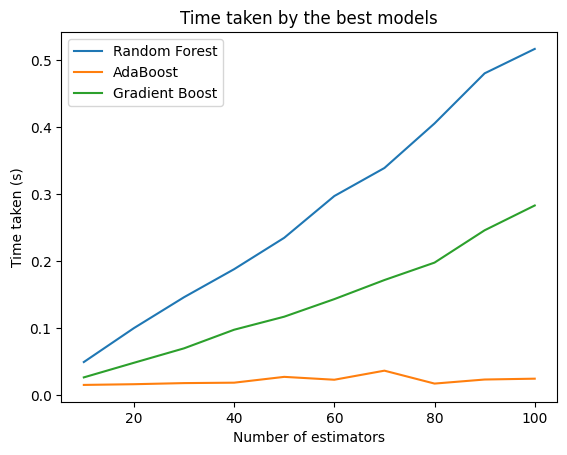

In [114]:
num_estimators_list = list((np.arange(10) + 1) * 10)

rf_times, ab_times, gb_times = [], [], []

for num_estimators in num_estimators_list:
    rf_time = time()
    best_rf_regressor = RandomForestRegressor(num_estimators=num_estimators, num_features_per_estimator=3, fraction=1, bootstrap=False, voting='hard', progress=False)
    best_rf_regressor.fit(housing_train_X, housing_train_Y)
    rf_times.append(time() - rf_time)

    ab_time = time()
    best_ab_regressor = AdaBoostRegressor(num_estimators=num_estimators, num_max_leaves=32, progress=False)
    best_ab_regressor.fit(housing_train_X, housing_train_Y)
    ab_times.append(time() - ab_time)

    gb_time = time()
    best_gb_regressor = GradientBoostRegressor(num_estimators=num_estimators, max_leaves=32, lr=1, progress=False)
    best_gb_regressor.fit(housing_train_X, housing_train_Y)
    gb_times.append(time() - gb_time)

    print(f"Trained on {num_estimators} estimators")

plt.plot(num_estimators_list, rf_times, label='Random Forest')
plt.plot(num_estimators_list, ab_times, label='AdaBoost')
plt.plot(num_estimators_list, gb_times, label='Gradient Boost')

plt.xlabel('Number of estimators')
plt.ylabel('Time taken (s)')
plt.title('Time taken by the best models')
plt.legend()

plt.show()

## Task 4.3 - Analysis

In [24]:
best_rf_classifier = RandomForestClassifier(num_estimators=20, num_features_per_estimator=9, fraction=0.15, bootstrap=False, voting='soft', progress=False)
best_rf_classifier.fit(wine_train_X, wine_train_Y)
best_rf_feature_importances = np.zeros((best_rf_classifier.num_estimators, wine_train_X.shape[1]))
for i, model in enumerate(best_rf_classifier.models):
    best_rf_feature_importances[i, best_rf_classifier.features[i]] = model.feature_importances_ 
rf_feature_importances = np.mean(best_rf_feature_importances, axis=0)

best_ab_classifier = AdaBoostClassifier(num_estimators=30, num_max_leaves=8, progress=False)
best_ab_classifier.fit(wine_train_X, wine_train_Y)
best_ab_feature_importances = []
for model in best_ab_classifier.models:
    best_ab_feature_importances.append(model.feature_importances_)
ab_feature_importances = np.mean(best_ab_feature_importances, axis=0)

best_gb_classifier = GradientBoostClassifier(num_estimators=70, max_leaves=None, lr=0.1, progress=False)
best_gb_classifier.fit(wine_train_X, wine_train_Y)
best_gb_feature_importances = []
for model in best_gb_classifier.models:
    best_gb_feature_importances.append(model.feature_importances_)
gb_feature_importances = np.mean(best_gb_feature_importances, axis=0)

print(rf_feature_importances)
print(ab_feature_importances)
print(gb_feature_importances)

[0.0462009  0.12847577 0.10884382 0.09500404 0.09810891 0.08799646
 0.12099972 0.05652945 0.05272002 0.11955115 0.08556975]
[0.         0.13333333 0.03333333 0.         0.36666667 0.03333333
 0.         0.         0.13333333 0.13333333 0.16666667]
[0.01425619 0.28394324 0.03732341 0.01394807 0.05787578 0.00713863
 0.1205446  0.0182448  0.01398705 0.4009396  0.0317986 ]


## Feature importance
- The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
<hr>

## Error analysis
- The features matching across models are as follows:
  - Random forest and adaboost          - `2, 8`
  - Random forest and gradient boosted  - `6`
  - Adaboost and gradient boosted       - `3`

- Hence, these feature similarities might influence similar errors

In [25]:
best_rf_regressor = RandomForestRegressor(num_estimators=5, num_features_per_estimator=3, fraction=1, bootstrap=False, voting='hard', progress=False)
best_rf_regressor.fit(housing_train_X, housing_train_Y)
best_rf_feature_importances = np.zeros((best_rf_regressor.num_estimators, housing_train_X.shape[1]))
for i, model in enumerate(best_rf_regressor.models):
    best_rf_feature_importances[i, best_rf_regressor.features[i]] = model.feature_importances_ 
rf_feature_importances = np.mean(best_rf_feature_importances, axis=0)

best_ab_regressor = AdaBoostRegressor(num_estimators=30, num_max_leaves=32, progress=False)
best_ab_regressor.fit(housing_train_X, housing_train_Y)
best_ab_feature_importances = []
for model in best_ab_regressor.models:
    best_ab_feature_importances.append(model.feature_importances_)
ab_feature_importances = np.mean(best_ab_feature_importances, axis=0)

best_gb_regressor = GradientBoostRegressor(num_estimators=20, max_leaves=32, lr=1, progress=False)
best_gb_regressor.fit(housing_train_X, housing_train_Y)
best_gb_feature_importances = []
for model in best_gb_regressor.models:
    best_gb_feature_importances.append(model.feature_importances_)
gb_feature_importances = np.mean(best_gb_feature_importances, axis=0)

print(rf_feature_importances)
print(ab_feature_importances)
print(gb_feature_importances)

[0.07115235 0.05006859 0.09858142 0.02555013 0.02312387 0.14533012
 0.         0.09514229 0.06060669 0.         0.07451724 0.17965926
 0.17626802]
[0.11764706 0.         0.         0.         0.         0.11764706
 0.         0.         0.         0.         0.         0.
 0.76470588]
[0.06869189 0.02621369 0.08943238 0.01245996 0.12845644 0.13873081
 0.06073794 0.12003493 0.0636531  0.05033551 0.06406163 0.06672356
 0.11046815]


## Feature importance
- The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
<hr>

## Error analysis
- The features matching across models are as follows:
  - Random forest and adaboost          - `6, 7, 10`
  - Random forest and gradient boosted  - `1, 6, 8, 9, 11`
  - Adaboost and gradient boosted       - `6`

- Hence, these feature similarities might influence similar errors